# Imports

In [1]:
import pickle
from itertools import cycle

import numpy as np
from scipy.spatial.distance import cdist

from khan_helpers import Experiment
from khan_helpers.constants import DATA_DIR, FIG_DIR
from khan_helpers.functions import set_figure_style


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Experiment & Participant classes, helper functions, and variables used across multiple notebooks can be found in `/opt/conda/lib/python3.9/site-packages/khan_helpers`, or on GitHub, [here](https://github.com/contextlab/efficient-learning-khan/tree/master/code/khan_helpers).<br />You can also view source code directly from the notebook with:<br /><pre>    from khan_helpers.functions import show_source<br />    show_source(foo)</pre>

# Load data containing peaks identified in `code/notebooks/supp/1_tables.ipynb`

In [2]:
exp = Experiment()

peak_intervals = pickle.loads(DATA_DIR.joinpath('qcorrs_peak_intervals.p').read_bytes())
palette = sns.hls_palette(15, h=.3)

# Plot each question's full correlation timecourse, peak timepoints, and surrounding interval identified in 

In [3]:
def plot_peaks(
    lecture_name, 
    palette=None, 
    peak_color='k', 
    in_alpha=1, 
    out_alpha=0.3
):
    if lecture_name == 'forces':
        min_qID = 1
        title = 'Four Fundamental Forces'
    elif lecture_name == 'bos':
        min_qID = 16
        title = 'Birth of Stars'
    else:
        raise ValueError('`lecture_name` must be either "forces" or "bos"')
        
    lecture = exp.get_lecture_traj(lecture_name)
    questions = exp.get_question_vecs(lectures=lecture_name)
    qcorrs = 1 - cdist(lecture, questions, 'correlation')
    
    peak_intervals_lec = peak_intervals[lecture_name]
    
    # if palette is None, returns the current Matplotlib color cycle
    palette = cycle(sns.color_palette(palette))
    
    fig, axarr = plt.subplots(5, 3, figsize=(20, 22), sharex=True, sharey=True)
    axarr = axarr.ravel()
    
    for q_ix, ax in enumerate(axarr):
        corr_timeseries = qcorrs[:, q_ix]
        color = next(palette)
        
        # plot full correlation timeseries
        ax.plot(corr_timeseries, c=color, alpha=out_alpha)
        ax.set_title(f'Q{q_ix + min_qID}', 
                     y=1.02, 
                     fontsize='large', 
                     fontweight='semibold')
        ax.set_xlim(0, len(lecture))
        ax.set_ylim(-.24, 1.05)
        ax.grid(visible=False)
        
        if q_ix >= 12:
            ticks = list(range(0, len(lecture), 60))
            ax.set_xticks(ticks, (f'{t // 60}:00' for t in ticks))
            ax.set_xlabel('Lecture time', fontsize='large', labelpad=10)
        else:
            ax.tick_params(bottom=False)
        if not q_ix % 3:
            ax.set_ylabel('Topic vector correlation', 
                          fontweight='semibold', 
                          labelpad=10)
        else:
            ax.tick_params(left=False)
        
        peaks, intervals = peak_intervals_lec[q_ix]
        if len(peaks) == 0:
            # no peaks identified for the given question
            continue
        
        # plot intervals
        for (onset_tpt, offset_tpt) in intervals:
            ax.plot(range(onset_tpt, offset_tpt), 
                    corr_timeseries[onset_tpt:offset_tpt], 
                    c=color, 
                    alpha=in_alpha, linewidth=3)
            
        # plot peaks
        ax.plot(peaks, 
                corr_timeseries[peaks], 
                c=color, 
                linestyle='', 
                marker='d', markersize=12, markeredgecolor=peak_color)
        
    fig.suptitle(f'Correlation timecourse peaks: {title}', 
                 y=1, 
                 fontsize='xx-large', 
                 fontweight='semibold')
                
    sns.despine()
    plt.tight_layout(h_pad=2)
    plt.show()
    return fig, axarr

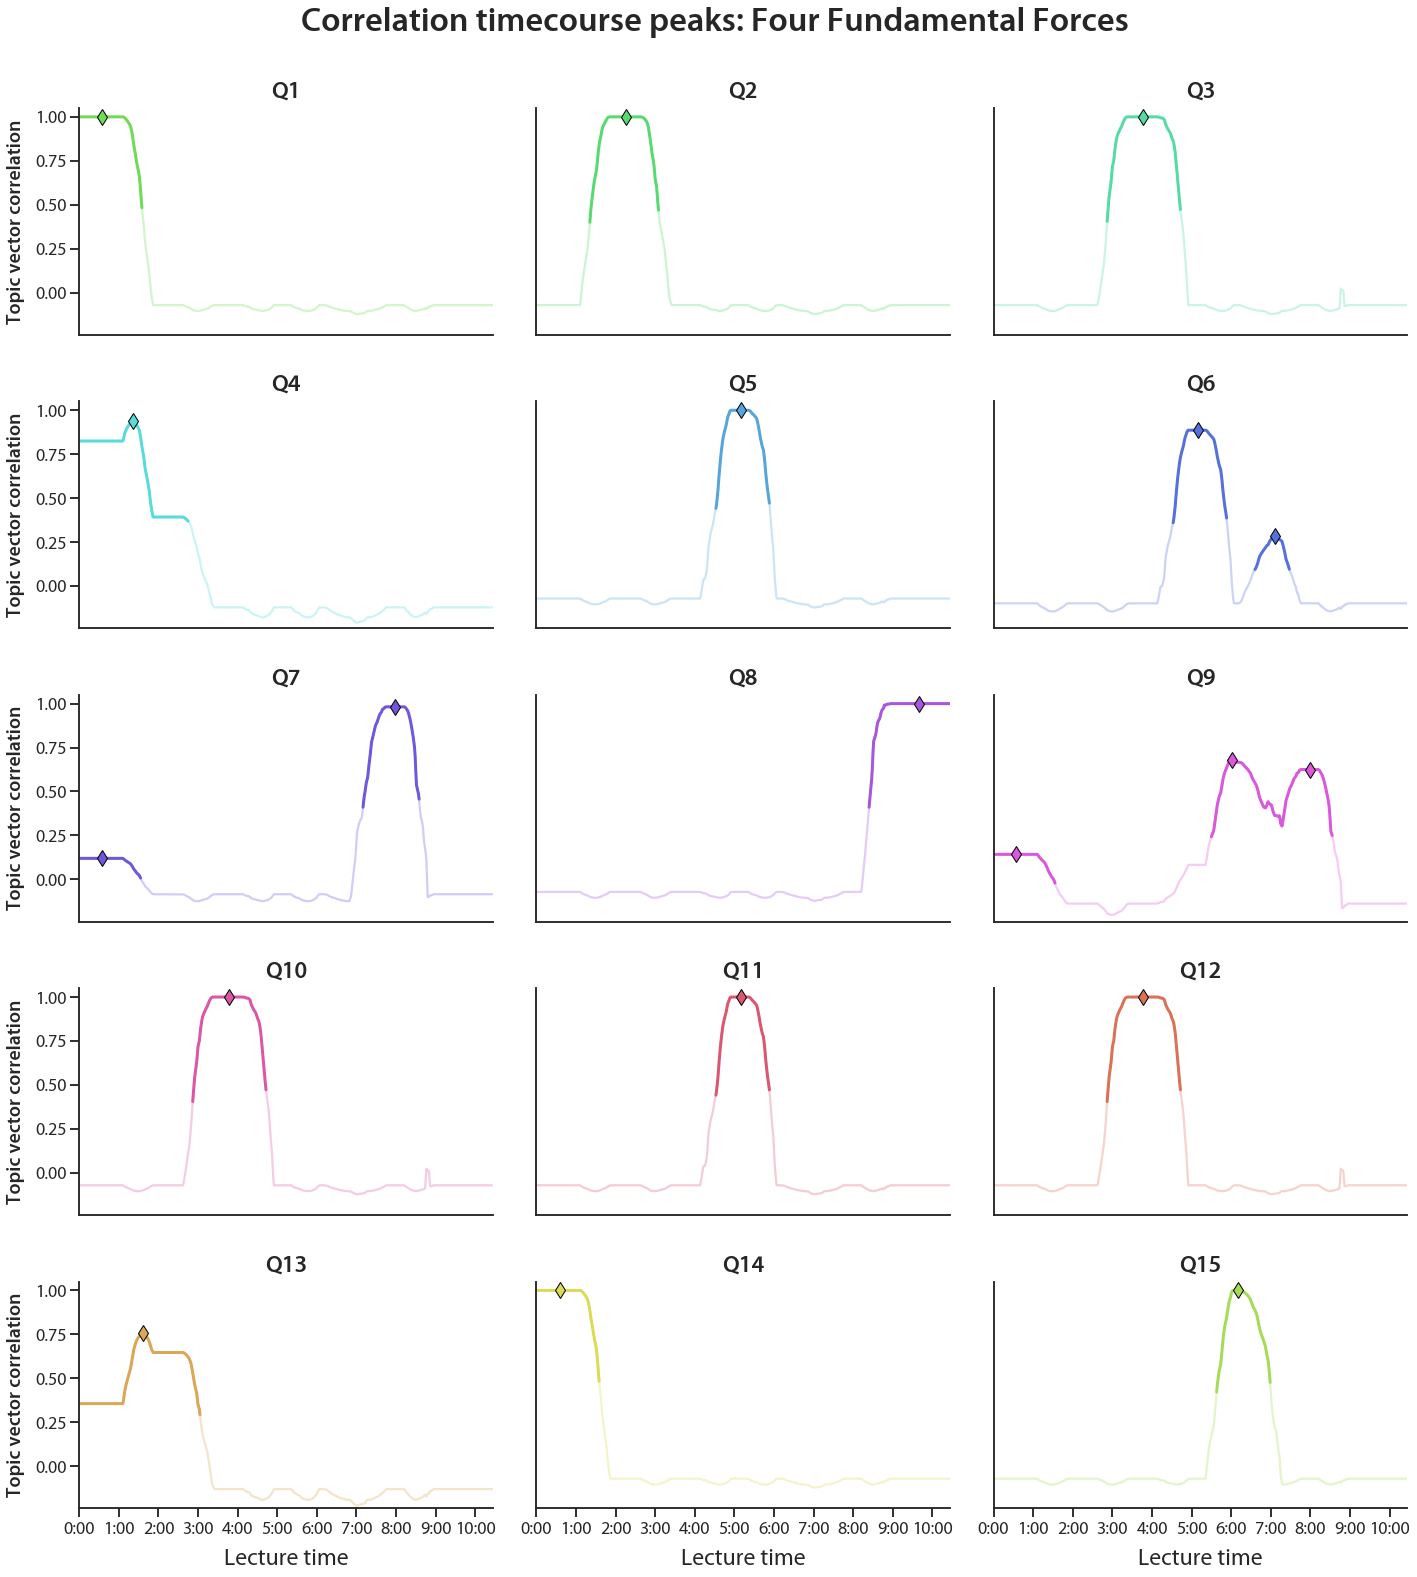

In [4]:
with sns.plotting_context('talk', font_scale=1.1), sns.axes_style('ticks'):
    set_figure_style()
    fig, _ = plot_peaks('forces', palette=palette)
#     fig.savefig(FIG_DIR.joinpath('forces-qcorrs-peaks.pdf'), bbox_inches='tight')

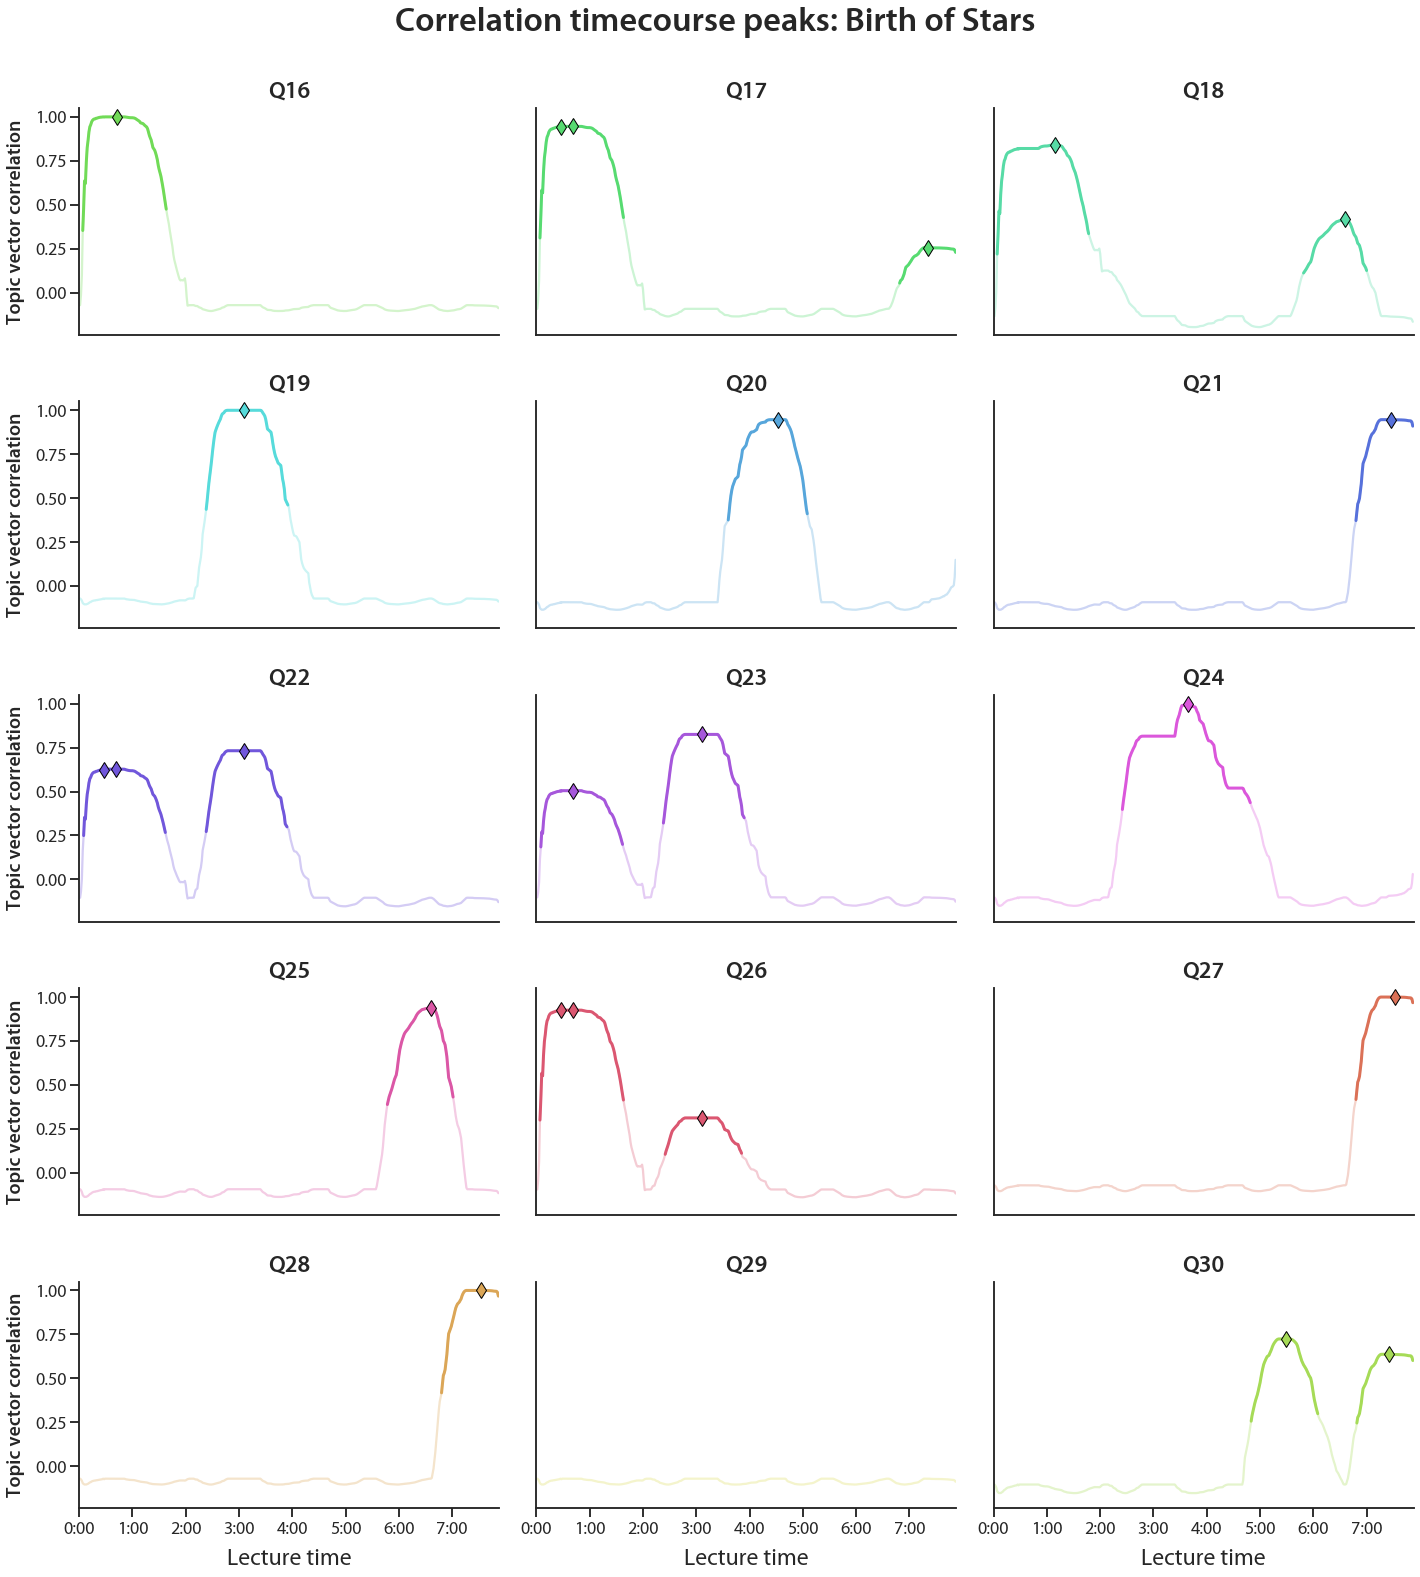

In [5]:
with sns.plotting_context('talk', font_scale=1.1), sns.axes_style('ticks'):
    set_figure_style()
    fig, _ = plot_peaks('bos', palette=palette)
#     fig.savefig(FIG_DIR.joinpath('bos-qcorrs-peaks.pdf'), bbox_inches='tight')